<a href="https://colab.research.google.com/github/Shanmukh200/Data-analysis/blob/main/Customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/content/Online Retail 1.csv', encoding='ISO-8859-1')

In [15]:
# Data Preprocessing
# Dropping rows with missing values in critical columns
df.dropna(subset=['CustomerID', 'InvoiceDate', 'Quantity', 'UnitPrice'], inplace=True)

In [16]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True)

In [17]:
# Add a column for Total Amount
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [18]:
# Creating RFM (Recency, Frequency, Monetary) table
rfm_table = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,
    'InvoiceNo': 'count',
    'TotalAmount': 'sum'
}).reset_index()

In [19]:
# Rename columns
rfm_table.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Ensure there are no NaN values in RFM table
rfm_table.dropna(inplace=True)

# Log transformation to normalize data
rfm_table['Recency'] = np.log(rfm_table['Recency'] + 1)
rfm_table['Frequency'] = np.log(rfm_table['Frequency'] + 1)
rfm_table['Monetary'] = np.log(rfm_table['Monetary'] + 1)

# Ensure there are no NaN values after log transformation
rfm_table.dropna(inplace=True)

# Check for NaN values in RFM table
print(rfm_table.isnull().sum())

CustomerID    0
Recency       0
Frequency     0
Monetary      0
dtype: int64


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
# Standardizing the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_table[['Recency', 'Frequency', 'Monetary']])

In [21]:
# Identify rows with NaN values in the scaled data
nan_rows = rfm_table[np.isnan(rfm_scaled).any(axis=1)]
print("Rows with NaN values in scaled data:")
print(nan_rows)

# Remove rows with NaN values in the scaled data
rfm_table = rfm_table.drop(index=nan_rows.index)
rfm_scaled = scaler.fit_transform(rfm_table[['Recency', 'Frequency', 'Monetary']])

# Check the shape of the scaled data and for NaN values
print(f"Shape of scaled RFM data: {rfm_scaled.shape}")
print(f"Any NaN values in scaled data: {np.isnan(rfm_scaled).any()}")

Rows with NaN values in scaled data:
Empty DataFrame
Columns: [CustomerID, Recency, Frequency, Monetary]
Index: []
Shape of scaled RFM data: (1430, 3)
Any NaN values in scaled data: False


In [23]:
# PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

# Check the shape of the PCA components and for NaN values
print(f"Shape of PCA components: {pca_components.shape}")
print(f"Any NaN values in PCA components: {np.isnan(pca_components).any()}")

Shape of PCA components: (1430, 2)
Any NaN values in PCA components: False


In [24]:
# K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pca_components)
rfm_table['Cluster'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


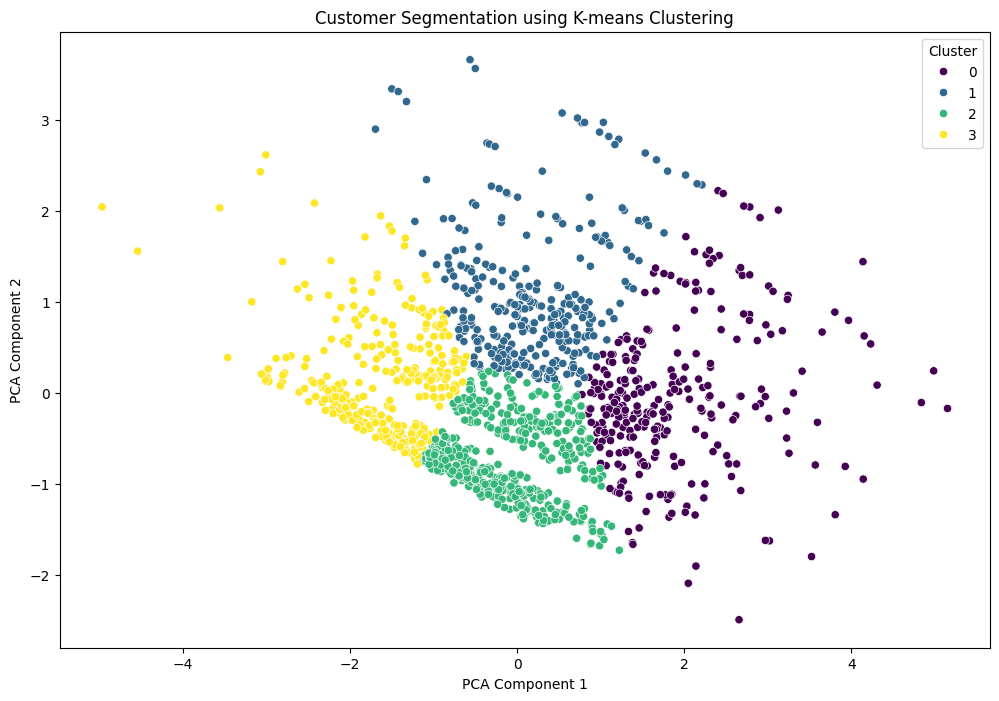

In [25]:
# Visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=rfm_table['Cluster'], palette='viridis')
plt.title('Customer Segmentation using K-means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [26]:
# Display the first few rows of the RFM table with clusters
print(rfm_table.head())

   CustomerID   Recency  Frequency  Monetary  Cluster
0     12346.0  3.178054   1.098612  0.000000        3
1     12347.0  2.708050   4.110874  7.080178        0
2     12348.0  2.833213   3.178054  7.022190        2
3     12350.0  2.079442   2.890372  5.815324        1
4     12356.0  3.178054   3.610918  7.728689        0
